# Breast Cancer Classification using BreastNet

This notebook demonstrates how to merge and preprocess datasets (IDC and BreaKHis), followed by training a custom neural network model called `BreastNet` for breast cancer histopathological image classification. The dataset used in this notebook is the Preprocessed BreakHis dataset and images from IDC.

### Step 1: Setup Environment and Import Libraries


In [ ]:
# Import necessary libraries
import os # Provides functions to interact with the operating system (e.g., file paths, directory operations)
import shutil # Offers high-level operations on files and collections of files (e.g., copying, deleting)
from glob import glob # Allows file pattern matching (e.g., *.jpg to get all JPEG files in a directory)
from PIL import Image # Python Imaging Library, used for opening, manipulating, and saving image files
from tqdm import tqdm # Displays a smart progress bar for loops
from sklearn.model_selection import train_test_split # Splits datasets into training and testing sets
from torchvision import datasets, transforms  # PyTorch library for vision datasets and image transformations
from torch.utils.data import DataLoader # Utility to efficiently load data in batches for training/testing
import torch.nn.functional as F # Functional API for neural network operations (e.g., activation functions)
import torch.nn as nn # Neural network layers (e.g., Linear, Conv2D) from PyTorch
import torch # Core PyTorch library

# Set paths
idc_root = r"D:\thisisimp\paper 2024\archive_extracted"  # Path to the IDC dataset
breakhis_root = r"D:\thisisimp\paper 2024\BreakHis\BreakHis - Breast Cancer Histopathological Database\dataset_cancer_v1\dataset_cancer_v1\classificacao_binaria"  # Path to the BreaKHis dataset
output_root = r"./merged_data"  # Path to the merged output directory
output_dir = r"./Preprocessed"  # Path to save preprocessed images

# Create output directories
os.makedirs(f"{output_root}/benign", exist_ok=True) # Create 'benign' subfolder in output if it doesn't exist
os.makedirs(f"{output_root}/malignant", exist_ok=True) # Create 'malignant' subfolder in output if it doesn't exist

# Set device (use GPU if available, otherwise use CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Automatically select CUDA GPU or fallback to CPU
print(f"[INFO] Using device: {device}") # Log the selected device


[INFO] Using device: cpu


### Step 2: Merge and Preprocess the IDC and BreaKHis Datasets

In this step, we will merge images from both IDC and BreaKHis datasets into one folder and preprocess them by resizing the images and organizing them into the appropriate class directories (`benign` and `malignant`).

- **IDC dataset**: Images are organized based on class labels `0` (benign) and `1` (malignant).
- **BreaKHis dataset**: We will merge the images from different magnifications (e.g., `40X`, `100X`, `200X`, `400X`) for both benign and malignant classes.


In [ ]:
# --- Copy BreaKHis Images --- #
print("Copying BreaKHis images...")  # Print message indicating the start of copying BreaKHis dataset images

for magnification in ["40X", "100X", "200X", "400X"]:# Loop through different magnification levels
    print(f"[DEBUG] Processing magnification: {magnification}") # Log the current magnification being processed
    for class_name in ["benign", "malignant"]:  # Loop through both classes
        image_paths = glob(os.path.join(breakhis_root, magnification, class_name, "*.png")) # Get all PNG image paths for the class and magnification
        print(f"[DEBUG] Found {len(image_paths)} {class_name} images in {magnification} magnification") # Log how many images were found
        for img_path in tqdm(image_paths, desc=f"BreaKHis {magnification} → {class_name}"): # Loop through images with progress bar
            try:
                filename = os.path.basename(img_path) # Extract the file name from the full path
                new_name = f"BreaKHis_{magnification}_{filename}" # Create a new name for the image including its source and magnification
                shutil.copy(img_path, f"{output_root}/{class_name}/{new_name}") # Copy the image to the appropriate output folder
            except Exception as e:
                print(f"[ERROR] Failed to copy {img_path}: {e}") # Print error message if the copy fails
                continue # Continue to the next image

# --- Copy IDC Images --- #
print("Copying IDC images...") # Print message indicating the start of copying IDC dataset images

for folder in glob(os.path.join(idc_root, "*")):  # Loop through all subfolders in the IDC root
    print(f"[DEBUG] Checking folder: {folder}")  # Log which folder is being checked
    for label in ['0', '1']:  # Loop through both labels: 0 for benign, 1 for malignant
        class_name = "benign" if label == '0' else "malignant" # Map label to class name
        print(f"[DEBUG] Processing class: {class_name}") # Log the class being processed
        label_folder = os.path.join(folder, label)  # Construct path to the label folder
        if os.path.isdir(label_folder): # Proceed only if it's a valid directory
            image_paths = glob(os.path.join(label_folder, "*.png")) # Get all PNG images in the label folder
            print(f"[DEBUG] Found {len(image_paths)} images in {label_folder}")  # Loop through images with progress bar
            for img_path in tqdm(image_paths, desc=f"IDC → {class_name}"):  # Loop through images with progress bar
                try:
                    filename = os.path.basename(img_path) # Extract file name
                    shutil.copy(img_path, f"{output_root}/{class_name}/IDC_{label}_{filename}") # Copy and rename the image to output folder
                except Exception as e:
                    print(f"[ERROR] Failed to copy {img_path}: {e}") # Print error if copy fails
                    continue # Skip to next image



Copying BreaKHis images...
[DEBUG] Processing magnification: 40X
[DEBUG] Found 625 benign images in 40X magnification


BreaKHis 40X → benign: 100%|██████████| 625/625 [00:11<00:00, 55.20it/s]


[DEBUG] Found 1370 malignant images in 40X magnification


BreaKHis 40X → malignant:  77%|███████▋  | 1061/1370 [00:31<00:09, 34.00it/s]


KeyboardInterrupt: 

### Step 3: Resize and Split the Dataset

We will resize all images to 224x224 pixels and then split the dataset into `train`, `val`, and `test` directories. This will be done for both the benign and malignant classes. We will use a 80-10-10 split for training, validation, and testing respectively.


In [ ]:
# Create output directories for train, val, and test splits
for split in ['train', 'val', 'test']:
    for cls in ['benign', 'malignant']:
        os.makedirs(f"{output_dir}/{split}/{cls}", exist_ok=True)
        print(f"[INFO] Created directory: {output_dir}/{split}/{cls}")

# Function to preprocess and split dataset
def preprocess_and_split(class_name):
    print(f"[INFO] Preprocessing and splitting {class_name} images...")
    image_paths = glob(f"{output_root}/{class_name}/*.png")
    print(f"[DEBUG] Found {len(image_paths)} {class_name} images")
    
    train, test = train_test_split(image_paths, test_size=0.2, random_state=42)
    print(f"[DEBUG] Split {len(train)} images for training and {len(test)} images for testing")
    
    train, val = train_test_split(train, test_size=0.1, random_state=42)
    print(f"[DEBUG] Split {len(train)} images for training and {len(val)} images for validation")
    
    for split, paths in zip(['train', 'val', 'test'], [train, val, test]):
        print(f"[INFO] Saving images to {split} split...")
        for img_path in tqdm(paths, desc=f"{class_name} → {split}"):
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((224, 224))  # Resize image
                img.save(f"{output_dir}/{split}/{class_name}/{os.path.basename(img_path)}")
            except Exception as e:
                print(f"[ERROR] Failed to process {img_path}: {e}")
                continue

# Preprocess and split the benign and malignant images
preprocess_and_split("benign")
preprocess_and_split("malignant")

print(" Preprocessing complete.")


[INFO] Created directory: ./Preprocessed/train/benign
[INFO] Created directory: ./Preprocessed/train/malignant
[INFO] Created directory: ./Preprocessed/val/benign
[INFO] Created directory: ./Preprocessed/val/malignant
[INFO] Created directory: ./Preprocessed/test/benign
[INFO] Created directory: ./Preprocessed/test/malignant
[INFO] Preprocessing and splitting benign images...
[DEBUG] Found 201218 benign images
[DEBUG] Split 160974 images for training and 40244 images for testing
[DEBUG] Split 144876 images for training and 16098 images for validation
[INFO] Saving images to train split...


benign → train: 100%|██████████| 144876/144876 [1:53:18<00:00, 21.31it/s]  


[INFO] Saving images to val split...


benign → val: 100%|██████████| 16098/16098 [19:11<00:00, 13.98it/s]  


[INFO] Saving images to test split...


benign → test: 100%|██████████| 40244/40244 [30:21<00:00, 22.10it/s]


[INFO] Preprocessing and splitting malignant images...
[DEBUG] Found 84215 malignant images
[DEBUG] Split 67372 images for training and 16843 images for testing
[DEBUG] Split 60634 images for training and 6738 images for validation
[INFO] Saving images to train split...


malignant → train: 100%|██████████| 60634/60634 [46:33<00:00, 21.71it/s]  


[INFO] Saving images to val split...


malignant → val: 100%|██████████| 6738/6738 [05:10<00:00, 21.67it/s]


[INFO] Saving images to test split...


malignant → test: 100%|██████████| 16843/16843 [12:56<00:00, 21.70it/s]

 Preprocessing complete.


### Step 4: Define Data Preprocessing and Load Datasets

We will now define the transformations for the images (e.g., resizing, normalization) and load the datasets for training, validation, and testing using PyTorch's `ImageFolder`.


In [ ]:
# Transforms for image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize images to 224x224
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize the image (mean=0.5, std=0.5)
])

# Load datasets using ImageFolder
batch_size = 32
print("[INFO] Loading datasets...")

train_loader = DataLoader(datasets.ImageFolder(f"{output_dir}/train", transform=transform), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(datasets.ImageFolder(f"{output_dir}/val", transform=transform), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(datasets.ImageFolder(f"{output_dir}/test", transform=transform), batch_size=batch_size, shuffle=False)

print("[INFO] Datasets loaded successfully.")


[INFO] Loading datasets...
[INFO] Datasets loaded successfully.


### Step 5: Define the Model Architecture

In this step, we define the custom model `BreastNet` which uses a Convolutional Neural Network (CNN) architecture with a channel attention mechanism.

The model uses a convolutional layer followed by a channel attention layer and an adaptive average pooling layer to reduce the dimensionality. Finally, it outputs a 2-class classification result (benign or malignant).


In [ ]:
# Define the Channel Attention mechanism
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, kernel_size=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.pool(x)
        out = self.relu(self.fc1(out))
        out = self.sigmoid(self.fc2(out))
        return x * out

# Define the BreastNet model
class BreastNet(nn.Module):
    def __init__(self):
        super(BreastNet, self).__init__()
        self.conv = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(32)
        self.attn = ChannelAttention(32)
        self.pool = nn.AdaptiveAvgPool2d((8, 8))  # Adaptive Pooling to reduce spatial size
        self.fc = nn.Linear(32 * 8 * 8, 2)  # Final fully connected layer for binary classification

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.attn(x)  # Apply channel attention
        x = self.pool(x)  # Apply adaptive pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor
        return self.fc(x)  # Output layer


### Step 6: Initialize the Model, Loss Function, and Optimizer

We will now initialize our model, define the loss function (CrossEntropyLoss) and optimizer (Adam), and begin training the model.


In [ ]:
# Initialize model
model = BreastNet().to(device)
print("[INFO] Model initialized.")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("[INFO] Loss function and optimizer defined.")


[INFO] Model initialized.
[INFO] Loss function and optimizer defined.


In [ ]:
# Define checkpoint directory
model_dir = r"D:\thisisimp\working-bc\models"
os.makedirs(model_dir, exist_ok=True)
print(f"[INFO] Checkpoint directory: {model_dir}")

[INFO] Checkpoint directory: D:\thisisimp\working-bc\models


### Step 7: Train the Breastnet Model

Now we will begin the training process, where the model will be trained for 10 epochs. During each epoch, we will calculate the training and validation loss and accuracy.


In [19]:
# Training Loop
num_epochs = 10
print("[INFO] Starting training...")

for epoch in range(resume_epoch, num_epochs):
    print(f"\n[Epoch {epoch+1}/{num_epochs}]")
    model.train()
    total, correct, running_loss = 0, 0, 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            print(f"  [Batch {batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}")

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_total, val_correct, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(val_loader)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    # Save checkpoint
    checkpoint_path = os.path.join(model_dir, f"breastnet_epoch{epoch+1}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_accuracy': val_acc
    }, checkpoint_path)
    print(f"[INFO] Model checkpoint saved at {checkpoint_path}")

print(" Training Complete.")


[INFO] Starting training...

[Epoch 6/10]
  [Batch 10/6423] Loss: 0.2309
  [Batch 20/6423] Loss: 0.2430
  [Batch 30/6423] Loss: 0.3289
  [Batch 40/6423] Loss: 0.2510
  [Batch 50/6423] Loss: 0.2366
  [Batch 60/6423] Loss: 0.1801
  [Batch 70/6423] Loss: 0.4678
  [Batch 80/6423] Loss: 0.2827
  [Batch 90/6423] Loss: 0.2383
  [Batch 100/6423] Loss: 0.3711
  [Batch 110/6423] Loss: 0.3094
  [Batch 120/6423] Loss: 0.2276
  [Batch 130/6423] Loss: 0.2171
  [Batch 140/6423] Loss: 0.3302
  [Batch 150/6423] Loss: 0.4311
  [Batch 160/6423] Loss: 0.3082
  [Batch 170/6423] Loss: 0.3750
  [Batch 180/6423] Loss: 0.2903
  [Batch 190/6423] Loss: 0.2632
  [Batch 200/6423] Loss: 0.3357
  [Batch 210/6423] Loss: 0.2134
  [Batch 220/6423] Loss: 0.4487
  [Batch 230/6423] Loss: 0.2333
  [Batch 240/6423] Loss: 0.2950
  [Batch 250/6423] Loss: 0.3762
  [Batch 260/6423] Loss: 0.3508
  [Batch 270/6423] Loss: 0.4404
  [Batch 280/6423] Loss: 0.4448
  [Batch 290/6423] Loss: 0.3596
  [Batch 300/6423] Loss: 0.2298
  [Batc

In [18]:
# Define model_dir if not already defined
model_dir = r"D:\thisisimp\working-bc\models"
os.makedirs(model_dir, exist_ok=True)

# Load checkpoint
resume_epoch = 5
checkpoint_path = os.path.join(model_dir, f"breastnet_epoch{resume_epoch}.pth")
if os.path.exists(checkpoint_path):
    print(f"[INFO] Loading checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"[INFO] Checkpoint loaded. Resuming from epoch {resume_epoch + 1}.")
else:
    raise FileNotFoundError(f"[ERROR] Checkpoint not found at {checkpoint_path}")


[INFO] Loading checkpoint from D:\thisisimp\working-bc\models\breastnet_epoch5.pth...
[INFO] Checkpoint loaded. Resuming from epoch 6.


### Step 8: Evaluate the Model on the Test Set

Finally, we evaluate the model on the test dataset to see its final performance.


In [22]:
# Testing the model
model.eval()  # Set the model to evaluation mode
test_total, test_correct = 0, 0
test_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Calculate test accuracy
test_acc = 100 * test_correct / test_total
test_loss = test_loss / len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Test Loss: 0.3131, Test Accuracy: 86.51%


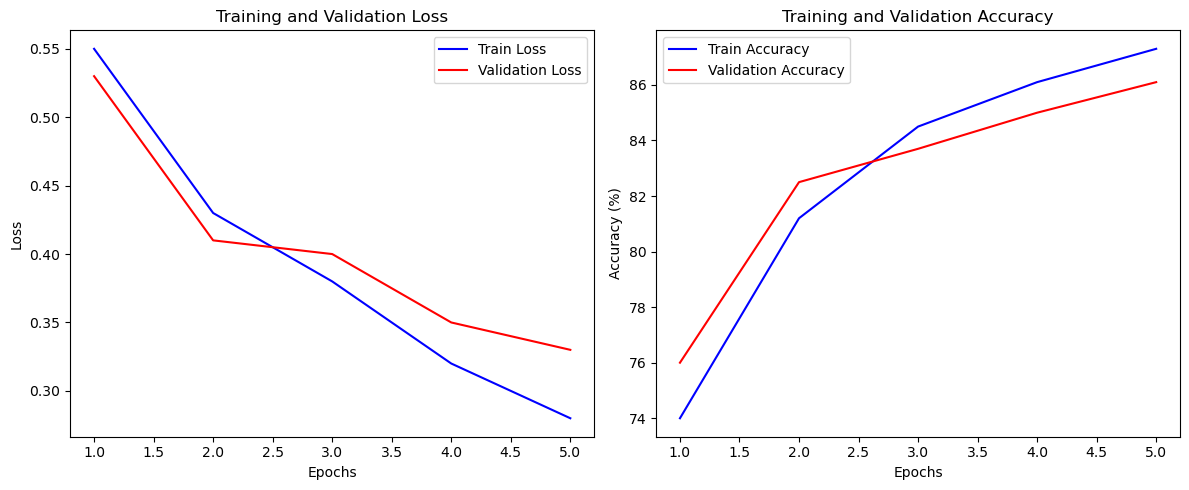

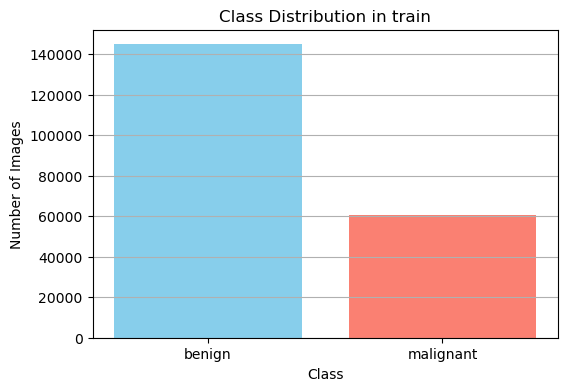

In [31]:
# metrics_visualization.py

import os
import matplotlib.pyplot as plt

# ---- PART 1: Accuracy and Loss Curves ----
def plot_accuracy_loss(train_loss, val_loss, train_acc, val_acc, save_path=None):
    """
    Plots training vs validation loss and accuracy curves.
    
    Parameters:
        train_loss (list): Training loss per epoch
        val_loss (list): Validation loss per epoch
        train_acc (list): Training accuracy per epoch
        val_acc (list): Validation accuracy per epoch
        save_path (str): Optional. Path to save the plot.
    """
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Train Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

# ---- PART 2: Class Distribution Plot ----
def plot_class_distribution(data_dir, save_path=None):
    """
    Plots the number of images per class in the specified directory.
    
    Parameters:
        data_dir (str): Path to dataset directory (train, val, or test)
        save_path (str): Optional. Path to save the plot.
    """
    classes = sorted(os.listdir(data_dir))
    counts = [len(os.listdir(os.path.join(data_dir, cls))) for cls in classes]

    plt.figure(figsize=(6, 4))
    plt.bar(classes, counts, color=['skyblue', 'salmon'])
    plt.title(f'Class Distribution in {os.path.basename(data_dir)}')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.grid(axis='y')

    if save_path:
        plt.savefig(save_path)
    plt.show()

# Example usage (you can comment this out if importing from another script)
if __name__ == '__main__':
    # Sample values for demonstration
    train_loss = [0.55, 0.43, 0.38, 0.32, 0.28]
    val_loss = [0.53, 0.41, 0.40, 0.35, 0.33]
    train_acc = [74.0, 81.2, 84.5, 86.1, 87.3]
    val_acc = [76.0, 82.5, 83.7, 85.0, 86.1]

    # Plot accuracy/loss curves
    plot_accuracy_loss(train_loss, val_loss, train_acc, val_acc)

    # Plot class distribution (adjust path as needed)
    data_directory = r"D:\thisisimp\working-bc\Preprocessed\train"
    plot_class_distribution(data_directory)


[INFO] Loading checkpoint: D:\thisisimp\working-bc\models\breastnet_epoch10.pth

Classification Report:

              precision    recall  f1-score   support

      benign       0.88      0.94      0.91     40244
   malignant       0.82      0.69      0.75     16843

    accuracy                           0.87     57087
   macro avg       0.85      0.81      0.83     57087
weighted avg       0.86      0.87      0.86     57087



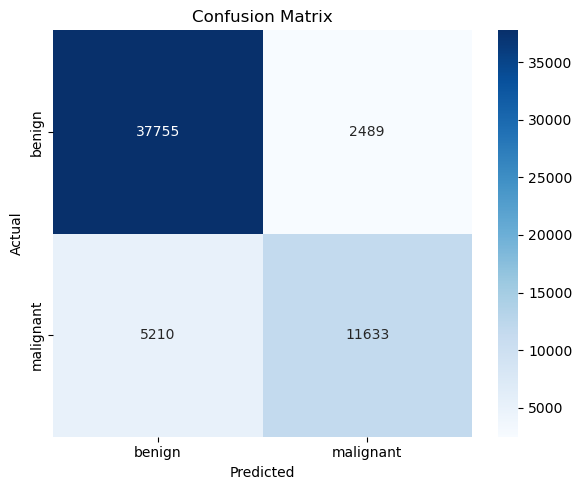

In [ ]:
# confusion_report.py

import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def evaluate_model(model, dataloader, device, class_names=None, save_path=None):
    """
    Evaluates the model on a given dataloader and plots a confusion matrix.

    Parameters:
        model (torch.nn.Module): Trained PyTorch model
        dataloader (torch.utils.data.DataLoader): DataLoader for the evaluation dataset
        device (torch.device): CPU or CUDA
        class_names (list): Names of classes (e.g., ["benign", "malignant"])
        save_path (str): Optional path to save the confusion matrix plot
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Classification Report
    if class_names:
        print("\nClassification Report:\n")
        print(classification_report(y_true, y_pred, target_names=class_names))
    else:
        print("\nClassification Report:\n")
        print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    if class_names is None:
        class_names = [str(i) for i in range(len(cm))]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

# Example usage:
if __name__ == '__main__':
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader
class ChannelAttention(torch.nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.pool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc1 = torch.nn.Conv2d(in_planes, in_planes // ratio, kernel_size=1)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Conv2d(in_planes // ratio, in_planes, kernel_size=1)
        self.sigmoid = torch.nn.Sigmoid()
        super(ChannelAttention, self).__init__()
        self.pool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc1 = torch.nn.Conv2d(in_planes, in_planes // ratio, kernel_size=1)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Conv2d(in_planes // ratio, in_planes, kernel_size=1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out = self.pool(x)
        out = self.relu(self.fc1(out))
        out = self.sigmoid(self.fc2(out))
        return x * out

class BreastNet(torch.nn.Module):
    def __init__(self):
        super(BreastNet, self).__init__()
        self.conv = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn = torch.nn.BatchNorm2d(32)
        self.attn = ChannelAttention(32)
        self.pool = torch.nn.AdaptiveAvgPool2d((8, 8))
        self.fc = torch.nn.Linear(32 * 8 * 8, 2)

    def forward(self, x):
        x = torch.nn.functional.relu(self.bn(self.conv(x)))
        x = self.attn(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

    # Define paths
    model_dir = r"D:\thisisimp\working-bc\models"
    data_root = r"D:\thisisimp\working-bc\Preprocessed"
    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    test_loader = DataLoader(
        datasets.ImageFolder(f"{data_root}/test", transform=transform),
        batch_size=batch_size, shuffle=False
    )

    # Auto-load the latest checkpoint
    checkpoints = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
    if checkpoints:
        latest_ckpt = max(checkpoints, key=lambda f: os.path.getmtime(os.path.join(model_dir, f)))
        ckpt_path = os.path.join(model_dir, latest_ckpt)
        print(f"[INFO] Loading checkpoint: {ckpt_path}")

        checkpoint = torch.load(ckpt_path, map_location=device)
        model = BreastNet().to(device)
        model.load_state_dict(checkpoint['model_state_dict'])

        # Evaluate model
        evaluate_model(model, test_loader, device, class_names=["benign", "malignant"])
    else:
        print("[ERROR] No model checkpoint found in directory:", model_dir)


[INFO] Loading checkpoint: D:\thisisimp\working-bc\models\breastnet_epoch10.pth


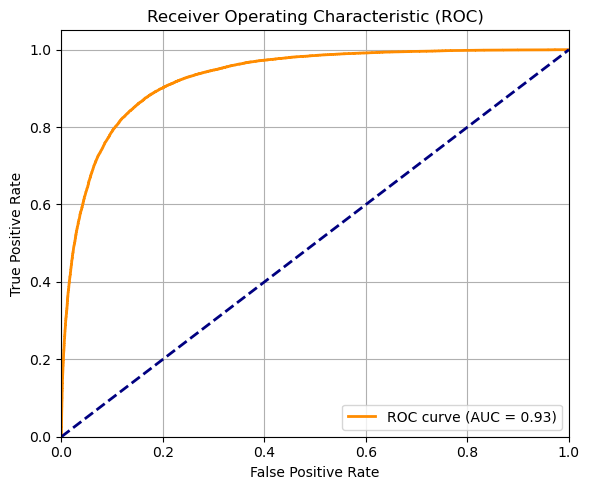

In [38]:
# roc_plot.py

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

class ChannelAttention(torch.nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.pool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc1 = torch.nn.Conv2d(in_planes, in_planes // ratio, kernel_size=1)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Conv2d(in_planes // ratio, in_planes, kernel_size=1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out = self.pool(x)
        out = self.relu(self.fc1(out))
        out = self.sigmoid(self.fc2(out))
        return x * out

class BreastNet(torch.nn.Module):
    def __init__(self):
        super(BreastNet, self).__init__()
        self.conv = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn = torch.nn.BatchNorm2d(32)
        self.attn = ChannelAttention(32)
        self.pool = torch.nn.AdaptiveAvgPool2d((8, 8))
        self.fc = torch.nn.Linear(32 * 8 * 8, 2)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.attn(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

if __name__ == '__main__':
    model_dir = r"D:\thisisimp\working-bc\models"
    data_root = r"D:\thisisimp\working-bc\Preprocessed"
    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model checkpoint
    checkpoints = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
    if not checkpoints:
        print("[ERROR] No model checkpoint found.")
        exit()

    latest_ckpt = max(checkpoints, key=lambda f: os.path.getmtime(os.path.join(model_dir, f)))
    ckpt_path = os.path.join(model_dir, latest_ckpt)
    print(f"[INFO] Loading checkpoint: {ckpt_path}")

    model = BreastNet().to(device)
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Load test set
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    test_loader = DataLoader(
        datasets.ImageFolder(f"{data_root}/test", transform=transform),
        batch_size=batch_size, shuffle=False
    )

    # Collect scores and labels
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)[:, 1]  # probability of class 1 (malignant)
            y_scores.extend(probs.cpu().numpy())
            y_true.extend(labels.numpy())

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [1]:
# gradcam.py

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import os
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# --- BreastNet and ChannelAttention ---
class ChannelAttention(torch.nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.pool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc1 = torch.nn.Conv2d(in_planes, in_planes // ratio, kernel_size=1)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Conv2d(in_planes // ratio, in_planes, kernel_size=1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out = self.pool(x)
        out = self.relu(self.fc1(out))
        out = self.sigmoid(self.fc2(out))
        return x * out

class BreastNet(torch.nn.Module):
    def __init__(self):
        super(BreastNet, self).__init__()
        self.conv = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn = torch.nn.BatchNorm2d(32)
        self.attn = ChannelAttention(32)
        self.pool = torch.nn.AdaptiveAvgPool2d((8, 8))
        self.fc = torch.nn.Linear(32 * 8 * 8, 2)
        self.feature_map = None
        self.gradient = None

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x.register_hook(self.save_gradient)
        self.feature_map = x
        x = self.attn(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

    def save_gradient(self, grad):
        self.gradient = grad

    def get_activations_gradient(self):
        return self.gradient

    def get_activations(self):
        return self.feature_map

In [2]:
# --- Grad-CAM Function ---
def generate_gradcam(model, image_tensor, device):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)
    output = model(image_tensor)
    class_idx = torch.argmax(output)

    model.zero_grad()
    output[0, class_idx].backward()

    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    activations = model.get_activations().detach()[0]
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=0).cpu()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap.numpy(), class_idx.item()

In [3]:
# --- Main: Load Image & Visualize ---
if __name__ == '__main__':
    # Configuration
    model_path = r"D:\thisisimp\working-bc\models\breastnet_epoch10.pth"  # Change if needed
    image_path = r"D:\thisisimp\working-bc\Preprocessed\test\malignant\BreaKHis_40X_SOB_M_DC-14-2523-40-011.png"  # Change this

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BreastNet().to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    orig_image = Image.open(image_path).convert('RGB')
    image_tensor = transform(orig_image)


In [4]:
# Generate Grad-CAM heatmap
heatmap, pred_class = generate_gradcam(model, image_tensor, device)

# Overlay heatmap on image
img_np = np.array(orig_image.resize((224, 224)))
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
overlayed = cv2.addWeighted(img_np, 0.5, heatmap, 0.5, 0)

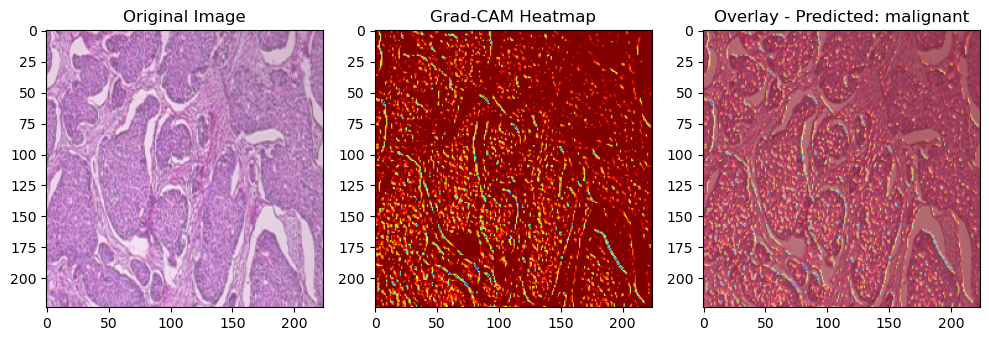

In [5]:
# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(orig_image)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")

plt.subplot(1, 3, 3)
plt.imshow(overlayed)
plt.title(f"Overlay - Predicted: {'malignant' if pred_class==1 else 'benign'}")

plt.tight_layout()
plt.show()

### Resnet18 Model

In [30]:
# resnet18_train.py
import os
import torch
import random
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset

# --- Setup ---
data_root = r"D:\thisisimp\working-bc\Preprocessed"
model_dir = r"D:\thisisimp\working-bc\resnet18 models"
os.makedirs(model_dir, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Transforms ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [31]:
# --- Dataset reduction ---
def reduce_dataset(dataset, percent=10, seed=42):
    total = len(dataset)
    k = int(total * percent / 100)
    random.seed(seed)
    indices = random.sample(range(total), k)
    return Subset(dataset, indices)

# --- Loaders ---
train_set = datasets.ImageFolder(f"{data_root}/train", transform=transform)
val_set = datasets.ImageFolder(f"{data_root}/val", transform=transform)

batch_size = 32
train_loader = DataLoader(reduce_dataset(train_set, 10), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(reduce_dataset(val_set, 10), batch_size=batch_size, shuffle=False)

In [32]:
# --- Model ---
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 output classes
model = model.to(device)

# --- Loss & Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- Metric storage ---
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
# --- Training ---
num_epochs = 10
print("[INFO] Starting ResNet18 training...")

for epoch in range(num_epochs):
    print(f"\n[Epoch {epoch+1}/{num_epochs}]")
    model.train()
    total, correct, running_loss = 0, 0, 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            print(f"  [Batch {batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}")

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- Validation ---
    model.eval()
    val_total, val_correct, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    # --- Save checkpoint ---
    checkpoint_path = os.path.join(model_dir, f"resnet18_epoch{epoch+1}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_accuracy': val_acc
    }, checkpoint_path)

print("ResNet18 Training Complete.")

[INFO] Starting ResNet18 training...

[Epoch 1/10]
  [Batch 10/643] Loss: 0.3896
  [Batch 20/643] Loss: 0.6924
  [Batch 30/643] Loss: 0.4064
  [Batch 40/643] Loss: 0.4976
  [Batch 50/643] Loss: 0.3830
  [Batch 60/643] Loss: 0.2938
  [Batch 70/643] Loss: 0.4682
  [Batch 80/643] Loss: 0.7961
  [Batch 90/643] Loss: 0.2994
  [Batch 100/643] Loss: 0.2807
  [Batch 110/643] Loss: 0.4050
  [Batch 120/643] Loss: 0.3978
  [Batch 130/643] Loss: 0.2362
  [Batch 140/643] Loss: 0.3499
  [Batch 150/643] Loss: 0.4252
  [Batch 160/643] Loss: 0.5145
  [Batch 170/643] Loss: 0.6109
  [Batch 180/643] Loss: 0.5237
  [Batch 190/643] Loss: 0.3803
  [Batch 200/643] Loss: 0.3749
  [Batch 210/643] Loss: 0.2348
  [Batch 220/643] Loss: 0.5110
  [Batch 230/643] Loss: 0.3226
  [Batch 240/643] Loss: 0.2967
  [Batch 250/643] Loss: 0.3476
  [Batch 260/643] Loss: 0.5818
  [Batch 270/643] Loss: 0.3976
  [Batch 280/643] Loss: 0.3045
  [Batch 290/643] Loss: 0.2182
  [Batch 300/643] Loss: 0.2650
  [Batch 310/643] Loss: 0.40

In [10]:
# --- Test Evaluation ---
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

data_root = r"D:\thisisimp\working-bc\Preprocessed"
model_dir = r"D:\thisisimp\working-bc\resnet18 models"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

print("\n[INFO] Evaluating on test set...")

# Load test set
test_loader = DataLoader(
    datasets.ImageFolder(os.path.join(data_root, "test"), transform=transform),
    batch_size=32, shuffle=False
)

# --- Rebuild ResNet18 architecture ---
from torchvision.models import ResNet18_Weights
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Load final model checkpoint
final_ckpt = os.path.join(model_dir, f"resnet18_epoch10.pth")
checkpoint = torch.load(final_ckpt, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Evaluation loop
test_correct, test_total, test_loss = 0, 0, 0.0
all_preds, all_labels = [], []
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds += predicted.cpu().tolist()
        all_labels += labels.cpu().tolist()

# Final metrics
from sklearn.metrics import classification_report
test_acc = 100 * test_correct / test_total
print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_acc:.2f}%")
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=["benign", "malignant"]))



[INFO] Evaluating on test set...
Test Loss: 0.3605, Test Accuracy: 86.29%

Classification Report:
               precision    recall  f1-score   support

      benign       0.89      0.92      0.90     40244
   malignant       0.79      0.73      0.76     16843

    accuracy                           0.86     57087
   macro avg       0.84      0.83      0.83     57087
weighted avg       0.86      0.86      0.86     57087



### vgg16 Model

In [3]:
# vgg16_train.py
import os
import random
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset

# --- Setup ---
data_root = r"D:\thisisimp\working-bc\Preprocessed"
model_dir = r"D:\thisisimp\working-bc\vgg16 models"
os.makedirs(model_dir, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Transforms ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [4]:
# --- Reduce Dataset ---
def reduce_dataset(dataset, percent=10, seed=42):
    total = len(dataset)
    k = int(total * percent / 100)
    random.seed(seed)
    indices = random.sample(range(total), k)
    return Subset(dataset, indices)

# --- Loaders ---
train_set = datasets.ImageFolder(f"{data_root}/train", transform=transform)
val_set = datasets.ImageFolder(f"{data_root}/val", transform=transform)

batch_size = 16
train_loader = DataLoader(reduce_dataset(train_set, 10), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(reduce_dataset(val_set, 10), batch_size=batch_size, shuffle=False)


In [10]:
# --- Model ---
num_classes = 2
from torchvision.models import VGG16_Weights
model = models.vgg16(weights=VGG16_Weights.DEFAULT)
model.classifier[6] = nn.Linear(4096, num_classes)
model = model.to(device)

# --- Loss & Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- Metric storage ---
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [11]:
#---Training---
num_epochs = 5
start_epoch = 0  # make sure to define this

print("[INFO] Starting VGG16 training...")

for epoch in range(start_epoch, num_epochs):
    print(f"\n[Epoch {epoch+1}/{num_epochs}]")
    model.train()
    total, correct, running_loss = 0, 0, 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            print(f"  [Batch {batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}")

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- Validation ---
    model.eval()
    val_total, val_correct, val_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # --- Save checkpoint ---
    checkpoint_path = os.path.join(model_dir, f"vgg16_epoch{epoch+1}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_acc': train_acc,
        'val_accuracy': val_acc
    }, checkpoint_path)

print("VGG16 Training Complete.")

[INFO] Starting VGG16 training...

[Epoch 1/5]
  [Batch 10/1285] Loss: 0.4798
  [Batch 20/1285] Loss: 0.4140
  [Batch 30/1285] Loss: 0.6716
  [Batch 40/1285] Loss: 0.5748
  [Batch 50/1285] Loss: 0.5848
  [Batch 60/1285] Loss: 0.6329
  [Batch 70/1285] Loss: 0.5677
  [Batch 80/1285] Loss: 0.6683
  [Batch 90/1285] Loss: 0.5708
  [Batch 100/1285] Loss: 0.4280
  [Batch 110/1285] Loss: 0.9854
  [Batch 120/1285] Loss: 0.5848
  [Batch 130/1285] Loss: 0.4785
  [Batch 140/1285] Loss: 0.7167
  [Batch 150/1285] Loss: 0.5484
  [Batch 160/1285] Loss: 0.6909
  [Batch 170/1285] Loss: 0.6152
  [Batch 180/1285] Loss: 0.5847
  [Batch 190/1285] Loss: 0.6504
  [Batch 200/1285] Loss: 0.6071
  [Batch 210/1285] Loss: 0.6675
  [Batch 220/1285] Loss: 0.5292
  [Batch 230/1285] Loss: 0.5956
  [Batch 240/1285] Loss: 0.5526
  [Batch 250/1285] Loss: 0.5978
  [Batch 260/1285] Loss: 0.6084
  [Batch 270/1285] Loss: 0.7942
  [Batch 280/1285] Loss: 0.7303
  [Batch 290/1285] Loss: 0.5397
  [Batch 300/1285] Loss: 0.6359
  

### vgg16 Model

In [14]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

# ------------------ Setup ------------------
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cpu")  # Force CPU

# Paths
train_path = r"D:\thisisimp\working-bc\Preprocessed\train"
val_path   = r"D:\thisisimp\working-bc\Preprocessed\val"
model_dir  = r"D:\thisisimp\working-bc\vgg16 models"
os.makedirs(model_dir, exist_ok=True)

# ------------------ Transform ------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Smaller size for CPU speed
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # Standard for VGG
])

# ------------------ Dataset ------------------
def reduce_dataset(dataset, percent):
    size = int(len(dataset) * percent / 100)
    indices = random.sample(range(len(dataset)), size)
    return Subset(dataset, indices)

train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)

train_subset = reduce_dataset(train_dataset, 20)
val_subset = reduce_dataset(val_dataset, 20)

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=16, shuffle=False)

# ------------------ Model ------------------
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
model = model.to(device)

# ------------------ Loss and Optimizer ------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ------------------ Training ------------------
num_epochs = 5
start_epoch = 1
best_val_acc = 0.0

for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

    # ----- Validation -----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # ----- Save checkpoint -----
    save_path = os.path.join(model_dir, f"vgg16_epoch_{epoch}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"[INFO] Saved model checkpoint: {save_path}")

    # ----- Save best model -----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_path = os.path.join(model_dir, "vgg16_best.pth")
        torch.save(model.state_dict(), best_path)
        print(f"[INFO] New best model saved with val accuracy: {best_val_acc:.4f}")


Epoch 1: 100%|██████████| 2569/2569 [7:40:51<00:00, 10.76s/it]  


Train Loss: 0.3447, Accuracy: 0.8534
Val Loss: 0.3114, Val Accuracy: 0.8592
[INFO] Saved model checkpoint: D:\thisisimp\working-bc\vgg16 models\vgg16_epoch_1.pth
[INFO] New best model saved with val accuracy: 0.8592


Epoch 2: 100%|██████████| 2569/2569 [8:28:12<00:00, 11.87s/it]    


Train Loss: 0.2904, Accuracy: 0.8799
Val Loss: 0.2931, Val Accuracy: 0.8807
[INFO] Saved model checkpoint: D:\thisisimp\working-bc\vgg16 models\vgg16_epoch_2.pth
[INFO] New best model saved with val accuracy: 0.8807


Epoch 3: 100%|██████████| 2569/2569 [7:55:20<00:00, 11.10s/it]  


Train Loss: 0.2632, Accuracy: 0.8901
Val Loss: 0.2515, Val Accuracy: 0.8934
[INFO] Saved model checkpoint: D:\thisisimp\working-bc\vgg16 models\vgg16_epoch_3.pth
[INFO] New best model saved with val accuracy: 0.8934


Epoch 4: 100%|██████████| 2569/2569 [7:12:14<00:00, 10.10s/it]   


Train Loss: 0.2401, Accuracy: 0.9010
Val Loss: 0.2620, Val Accuracy: 0.8879
[INFO] Saved model checkpoint: D:\thisisimp\working-bc\vgg16 models\vgg16_epoch_4.pth


Epoch 5: 100%|██████████| 2569/2569 [7:01:53<00:00,  9.85s/it]  


Train Loss: 0.2049, Accuracy: 0.9177
Val Loss: 0.2894, Val Accuracy: 0.8896
[INFO] Saved model checkpoint: D:\thisisimp\working-bc\vgg16 models\vgg16_epoch_5.pth


### Densetnet Model

In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import random

# --- Setup ---
device = torch.device("cpu")

# Paths
train_path = 'D:/thisisimp/working-bc/Preprocessed/train'
val_path = 'D:/thisisimp/working-bc/Preprocessed/val'
model_dir = r"D:\thisisimp\working-bc\Densenet model"
checkpoint_path = os.path.join(model_dir, "densenet_epoch_2.pth")
best_model_path = os.path.join(model_dir, "densenet_best.pth")

# --- Transform ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# --- Dataset ---
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)

# Reduce to 20%
train_subset = Subset(train_dataset, random.sample(range(len(train_dataset)), int(0.2 * len(train_dataset))))
val_subset = Subset(val_dataset, random.sample(range(len(val_dataset)), int(0.2 * len(val_dataset))))

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False, num_workers=0)

# --- Model ---
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = nn.Linear(model.classifier.in_features, 2)
model = model.to(device)

# --- Load checkpoint (resume from epoch 3) ---
optimizer = optim.Adam(model.parameters(), lr=1e-4)
start_epoch = 3
best_val_acc = 0

if os.path.exists(checkpoint_path):
    print(f"[INFO] Loading checkpoint from {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path))
    if os.path.exists(best_model_path):
        print(f"[INFO] Also loading best model to resume best accuracy tracking.")
        best_model_state = torch.load(best_model_path)
        model.load_state_dict(best_model_state)

# --- Loss ---
criterion = nn.CrossEntropyLoss()

# --- Training loop ---
num_epochs = 5

for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # --- Save current epoch ---
    save_path = os.path.join(model_dir, f"densenet_epoch_{epoch}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"Saved model checkpoint: {save_path}")

    # --- Save best ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with val accuracy: {best_val_acc:.4f}")


[INFO] Loading checkpoint from D:\thisisimp\working-bc\Densenet model\densenet_epoch_2.pth
[INFO] Also loading best model to resume best accuracy tracking.


Epoch 3: 100%|██████████| 2569/2569 [2:14:34<00:00,  3.14s/it]  


Train Loss: 0.2688, Accuracy: 0.8879
Val Loss: 0.2750, Val Accuracy: 0.8875
Saved model checkpoint: D:\thisisimp\working-bc\Densenet model\densenet_epoch_3.pth
New best model saved with val accuracy: 0.8875


Epoch 4: 100%|██████████| 2569/2569 [5:16:57<00:00,  7.40s/it]     


Train Loss: 0.2361, Accuracy: 0.9027
Val Loss: 0.2681, Val Accuracy: 0.8892
Saved model checkpoint: D:\thisisimp\working-bc\Densenet model\densenet_epoch_4.pth
New best model saved with val accuracy: 0.8892


Epoch 5: 100%|██████████| 2569/2569 [2:12:41<00:00,  3.10s/it]  


Train Loss: 0.2029, Accuracy: 0.9163
Val Loss: 0.2595, Val Accuracy: 0.8958
Saved model checkpoint: D:\thisisimp\working-bc\Densenet model\densenet_epoch_5.pth
New best model saved with val accuracy: 0.8958


Compare Models

In [27]:
# compare_models.py
import os
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix, roc_curve, auc

# --- Setup ---
data_root = r"D:\thisisimp\working-bc\Preprocessed"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# --- Load test set ---
test_loader = DataLoader(
    datasets.ImageFolder(os.path.join(data_root, "test"), transform=transform),
    batch_size=batch_size, shuffle=False
)

results = []

def evaluate_model(model, checkpoint_path, name):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    all_probs = []
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds += predicted.cpu().tolist()
            all_labels += labels.cpu().tolist()
            all_probs += probs.cpu().tolist()

    acc = 100 * correct / total
    print(f"\n{name} - Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {acc:.2f}%")
    print(classification_report(all_labels, all_preds, target_names=["benign", "malignant"]))

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    results.append({
        "model": name,
        "accuracy": acc,
        "precision": precision * 100,
        "recall": recall * 100,
        "f1_score": f1 * 100
    })

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_{name}.png")
    plt.clf()

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# --- Models ---
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, kernel_size=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.pool(x)
        out = self.relu(self.fc1(out))
        out = self.sigmoid(self.fc2(out))
        return x * out

class BreastNet(nn.Module):
    def __init__(self):
        super(BreastNet, self).__init__()
        self.conv = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(32)
        self.attn = ChannelAttention(32)
        self.pool = nn.AdaptiveAvgPool2d((8, 8))
        self.fc = nn.Linear(32 * 8 * 8, 2)

    def forward(self, x):
        x = torch.relu(self.bn(self.conv(x)))
        x = self.attn(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# --- Model Loader Functions ---
def get_breastnet():
    return BreastNet().to(device)

def get_resnet18():
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model.to(device)

def get_vgg16():
    model = models.vgg16(weights=None)
    model.classifier[6] = nn.Linear(4096, 2)
    return model.to(device)

# --- Paths with .format() placeholder for epochs ---
base_paths = {
    "BreastNet": r"D:\\thisisimp\\working-bc\\models\\breastnet_epoch{}.pth",
    "ResNet18": r"D:\\thisisimp\\working-bc\\resnet18 models\\resnet18_epoch{}.pth",
    "VGG16": r"D:\\thisisimp\\working-bc\\vgg16 models\\vgg16_epoch{}.pth"
}

model_getters = {
    "BreastNet": get_breastnet,
    "ResNet18": get_resnet18,
    "VGG16": get_vgg16
}

# --- Evaluate each epoch (up to 5 only) ---
for model_name in ["BreastNet", "ResNet18", "VGG16"]:
    for epoch in range(1, 6):  # Epochs 1 to 5
        checkpoint_path = base_paths[model_name].format(epoch)
        if not os.path.exists(checkpoint_path):
            print(f"\u274c Missing: {checkpoint_path}")
            continue
        model = model_getters[model_name]()
        eval_name = f"{model_name}_epoch{epoch}"
        evaluate_model(model, checkpoint_path, eval_name)

# --- Save and Plot Results ---
results_df = pd.DataFrame(results)
results_df.to_csv("model_epoch_comparison_results.csv", index=False)

plt.figure(figsize=(12, 6))
for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
    plt.plot(results_df['model'], results_df[metric], label=metric, marker='o')

plt.title("Model Epoch Comparison")
plt.xlabel("Model (Epoch)")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("model_epoch_comparison_plot.png")
plt.show()

plt.title("ROC Curve Comparison")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_comparison_plot.png")
plt.show()



BreastNet_epoch1 - Test Loss: 0.3401, Accuracy: 85.22%
              precision    recall  f1-score   support

      benign       0.88      0.92      0.90     40244
   malignant       0.78      0.70      0.74     16843

    accuracy                           0.85     57087
   macro avg       0.83      0.81      0.82     57087
weighted avg       0.85      0.85      0.85     57087


BreastNet_epoch2 - Test Loss: 0.3376, Accuracy: 85.55%
              precision    recall  f1-score   support

      benign       0.88      0.93      0.90     40244
   malignant       0.79      0.69      0.74     16843

    accuracy                           0.86     57087
   macro avg       0.84      0.81      0.82     57087
weighted avg       0.85      0.86      0.85     57087



C:\Users\Dell\AppData\Local\Temp\ipykernel_4576\1425285216.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()



BreastNet_epoch3 - Test Loss: 0.3287, Accuracy: 85.88%
              precision    recall  f1-score   support

      benign       0.88      0.92      0.90     40244
   malignant       0.79      0.71      0.75     16843

    accuracy                           0.86     57087
   macro avg       0.84      0.82      0.83     57087
weighted avg       0.86      0.86      0.86     57087



C:\Users\Dell\AppData\Local\Temp\ipykernel_4576\1425285216.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()



BreastNet_epoch4 - Test Loss: 0.3557, Accuracy: 84.61%
              precision    recall  f1-score   support

      benign       0.92      0.86      0.89     40244
   malignant       0.71      0.82      0.76     16843

    accuracy                           0.85     57087
   macro avg       0.81      0.84      0.82     57087
weighted avg       0.86      0.85      0.85     57087



C:\Users\Dell\AppData\Local\Temp\ipykernel_4576\1425285216.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()



BreastNet_epoch5 - Test Loss: 0.3201, Accuracy: 86.41%
              precision    recall  f1-score   support

      benign       0.91      0.89      0.90     40244
   malignant       0.76      0.80      0.78     16843

    accuracy                           0.86     57087
   macro avg       0.83      0.84      0.84     57087
weighted avg       0.87      0.86      0.87     57087



C:\Users\Dell\AppData\Local\Temp\ipykernel_4576\1425285216.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()



ResNet18_epoch1 - Test Loss: 0.3450, Accuracy: 86.72%
              precision    recall  f1-score   support

      benign       0.89      0.93      0.91     40244
   malignant       0.80      0.73      0.76     16843

    accuracy                           0.87     57087
   macro avg       0.85      0.83      0.84     57087
weighted avg       0.86      0.87      0.87     57087



C:\Users\Dell\AppData\Local\Temp\ipykernel_4576\1425285216.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()



ResNet18_epoch2 - Test Loss: 0.3177, Accuracy: 86.62%
              precision    recall  f1-score   support

      benign       0.87      0.95      0.91     40244
   malignant       0.84      0.68      0.75     16843

    accuracy                           0.87     57087
   macro avg       0.86      0.81      0.83     57087
weighted avg       0.86      0.87      0.86     57087



C:\Users\Dell\AppData\Local\Temp\ipykernel_4576\1425285216.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()



ResNet18_epoch3 - Test Loss: 0.3220, Accuracy: 86.90%
              precision    recall  f1-score   support

      benign       0.90      0.91      0.91     40244
   malignant       0.79      0.76      0.77     16843

    accuracy                           0.87     57087
   macro avg       0.84      0.84      0.84     57087
weighted avg       0.87      0.87      0.87     57087



C:\Users\Dell\AppData\Local\Temp\ipykernel_4576\1425285216.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()



ResNet18_epoch4 - Test Loss: 0.3279, Accuracy: 86.57%
              precision    recall  f1-score   support

      benign       0.87      0.95      0.91     40244
   malignant       0.84      0.67      0.75     16843

    accuracy                           0.87     57087
   macro avg       0.86      0.81      0.83     57087
weighted avg       0.86      0.87      0.86     57087



C:\Users\Dell\AppData\Local\Temp\ipykernel_4576\1425285216.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()



ResNet18_epoch5 - Test Loss: 0.3095, Accuracy: 87.23%
              precision    recall  f1-score   support

      benign       0.90      0.92      0.91     40244
   malignant       0.80      0.76      0.78     16843

    accuracy                           0.87     57087
   macro avg       0.85      0.84      0.84     57087
weighted avg       0.87      0.87      0.87     57087



C:\Users\Dell\AppData\Local\Temp\ipykernel_4576\1425285216.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()



VGG16_epoch1 - Test Loss: 0.6078, Accuracy: 70.50%


c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\

              precision    recall  f1-score   support

      benign       0.70      1.00      0.83     40244
   malignant       0.00      0.00      0.00     16843

    accuracy                           0.70     57087
   macro avg       0.35      0.50      0.41     57087
weighted avg       0.50      0.70      0.58     57087



C:\Users\Dell\AppData\Local\Temp\ipykernel_4576\1425285216.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


: 